## Load Data

This dataset [Electricity Load Diagrams 20112014 Data Set](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#) is from UCI Machine Learning Repository.

### Data Set Information:

Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [ ]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip --output LD2011_2014.txt.zip
!unzip LD2011_2014.txt.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  249M  100  249M    0     0  35.8M      0  0:00:06  0:00:06 --:--:-- 40.9M
Archive:  LD2011_2014.txt.zip
  inflating: LD2011_2014.txt         
   creating: __MACOSX/
  inflating: __MACOSX/._LD2011_2014.txt  
LD2011_2014.txt  LD2011_2014.txt.zip  __MACOSX	sample_data


In [ ]:
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
df = pd.read_csv("LD2011_2014.txt", sep = ';', index_col = 0, dtype=str)

In [ ]:
print(df.shape)

(140256, 370)


# Data processing & Pre-Modeling

## Data Cleaning

- Melt the wide data matrix to long data matrix
- Convert index to timestamps, entries to numeric

In [ ]:
def preprocessing(dataframe):
    # convert index (timestamp) to a new column
    dataframe = dataframe.reset_index().rename(columns={"index": "timestamp"})

    # unpivot the data
    dataframe = dataframe.melt(id_vars=['timestamp'], var_name='user', value_name='usage_per_15min')
    # fix the timestamp
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], format = '%Y-%m-%d %H:%M:%S')
    # fix electricity usage
    dataframe['usage_per_15min'] = dataframe['usage_per_15min'].apply(lambda x: str(x).replace(',', '.')).astype(float)

    return dataframe

df = preprocessing(df)

In [ ]:
def aggregate_date(dataframe):
    dataframe['date'] = pd.to_datetime((dataframe.timestamp - np.timedelta64(1, 'm')).dt.date)
    dataframe_day = dataframe.groupby(['user', 'date']).sum().reset_index()
    dataframe_day = dataframe_day.rename(columns={'usage_per_15min': 'sum_per_day'})
    dataframe_day['std_per_day'] = dataframe.groupby(['user', 'date']).std().reset_index().usage_per_15min

    return dataframe_day

df_day = aggregate_date(df)
df_day.head()

,user,date,sum_per_day,std_per_day
0,MT_001,2011-01-01,0.0,0.0
1,MT_001,2011-01-02,0.0,0.0
2,MT_001,2011-01-03,0.0,0.0
3,MT_001,2011-01-04,0.0,0.0
4,MT_001,2011-01-05,0.0,0.0


user
MT_012    605
MT_015    629
MT_030    493
MT_039    640
MT_041    620
MT_092    395
MT_106    743
MT_107    743
MT_108    743
MT_109    778
MT_110    743
MT_111    743
MT_112    772
MT_113    743
MT_115    743
MT_116    778
MT_117    743
MT_120    743
MT_121    743
MT_122    743
MT_133    801
MT_160    764
MT_165    612
MT_170    423
MT_178    929
MT_179    719
MT_181    794
MT_185    536
MT_186    633
MT_223    829
MT_224    539
MT_289    697
MT_305    707
MT_322    606
MT_337    747
MT_347    622
Name: sum_per_day, dtype: int64


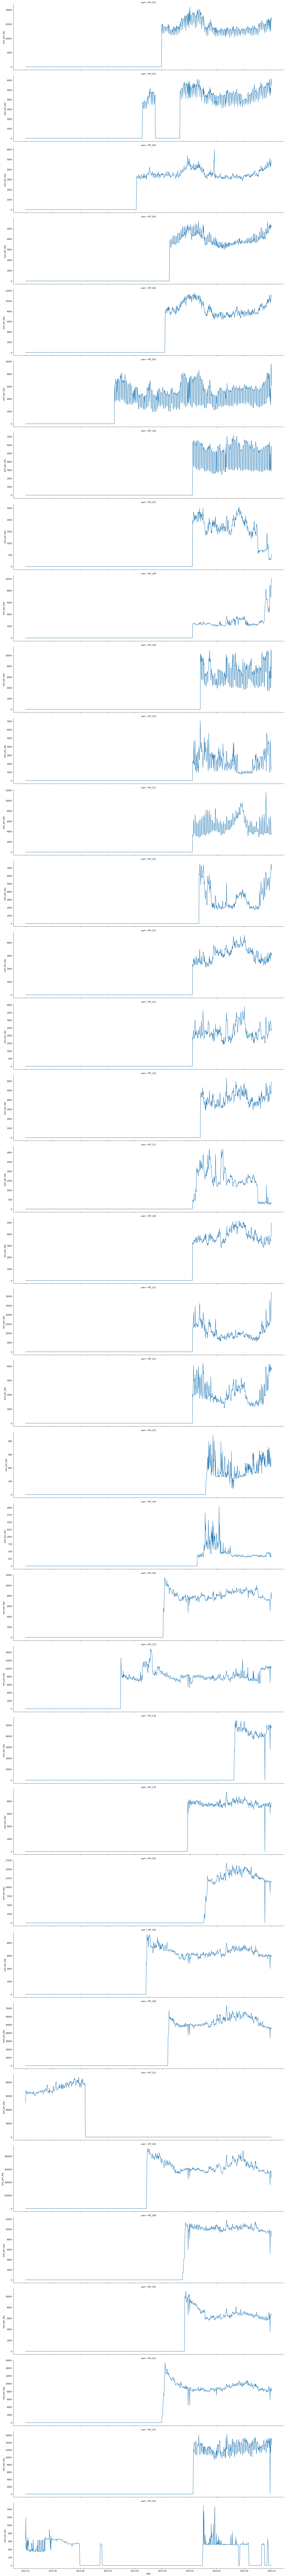

In [ ]:
def cleaning(dataframe, threshold=90):
    dataframe = dataframe.copy(deep=True)
    dataframe = dataframe[dataframe.date.dt.year >= 2012]
    # remove the extra day in leap year
    dataframe = dataframe[dataframe.date != pd.to_datetime('20120229')]

    # find users that are active since 2012
    # active_user = [user for user in dataframe.user.unique() if dataframe[(dataframe.user==user) * (dataframe.date==pd.to_datetime('20120101'))].sum_per_day.item() > 0]
    # dataframe = dataframe[dataframe.user.isin(active_user)]

    def without_leading_consecutive_zeros(dataframe, threshold, by="user", col="sum_per_day"):
        # reference: https://datascience.stackexchange.com/questions/20587/find-the-consecutive-zeros-in-a-dataframe-and-do-a-conditional-replacement
        group = dataframe.groupby(by=by)[col].apply(lambda x: (~((x == x.shift()) & (x == 0))).cumsum())
        mask = dataframe[col].groupby(group).transform('count').lt(threshold)
        mask |= (group != 1)
        return mask

    # mask = without_leading_consecutive_zeros(dataframe, threshold)
    # print(f'dropping {(~mask).sum()} rows with leading zeros...')
    # dataframe = dataframe.loc[mask, :]

    # count 0 usage days
    zero_count = dataframe.groupby('user')['sum_per_day'].apply(lambda x: np.sum(x == 0))
    abnormal = zero_count[zero_count > 370]
    print(abnormal)

    sns.relplot(data=dataframe[dataframe.user.isin(abnormal.index)], 
            x="date", y="sum_per_day", row="user",
            kind="line", aspect=4, facet_kws={'sharey': False})

    dataframe = dataframe[~dataframe.user.isin(abnormal.index)]

    return dataframe

df_day_clean = cleaning(df_day)

## Visualize the Dataset

Have a look on the dataset, visualize if there are any trends or seasonality. 

In [ ]:

# select 3 random users 
np.random.seed(32)
random_id = np.random.choice(df_day_clean.user.unique().__len__(), 3)
selected_users = df_day_clean.user.unique()[random_id]
print(f'Selected user ids: {selected_users}')

sample_df = df_day_clean[df_day_clean.user.isin(selected_users)]

Selected user ids: ['MT_247' 'MT_049' 'MT_346']


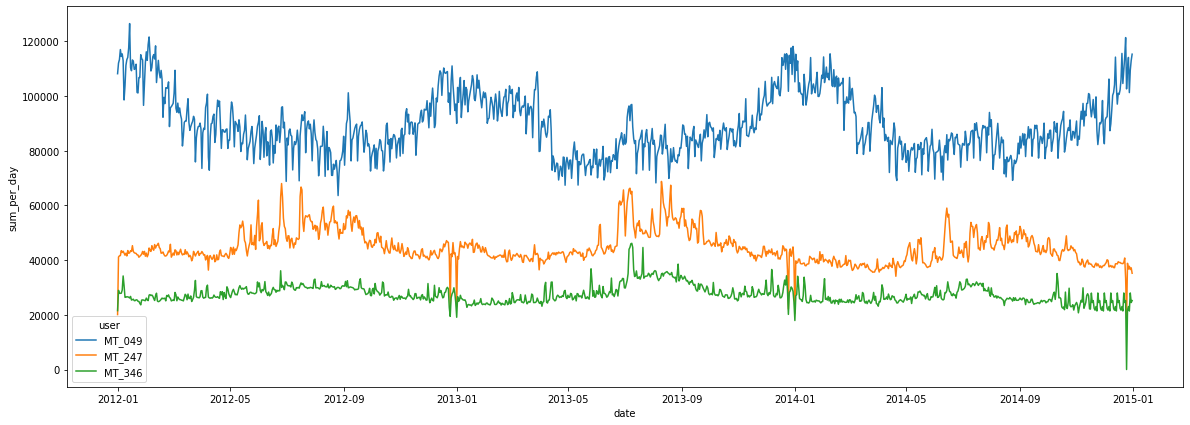

In [ ]:
plt.figure(figsize=(20,7))
sns.lineplot(data=sample_df, x="date", y="sum_per_day", hue="user")

## Create features

ex. lag, rolling statistics ... 

In [ ]:
def feature_engineering(dataframe_raw, train_test_cutoff = pd.to_datetime('20140101')):

    dataframe = dataframe_raw.copy(deep=True)

    # normalize = (x - mean)/std
    # columns = dataframe.drop(["user", "date"], axis=1).columns
    # columns = ['sum_per_day']

    train_scale_by_user = dataframe.query("date < @train_test_cutoff").groupby("user").sum_per_day.agg(['mean', 'std'])
    train_scale_by_user.rename(columns={'mean': 'overall_mean', 'std': 'overall_std'}, inplace=True)
    # train_scale_by_user.columns = ["_".join(i) for i in train_scale_by_user.columns.to_flat_index()]
    dataframe = dataframe.join(train_scale_by_user, on="user", how="left")

    # for c in columns: 
    # dataframe.sum_per_day = (dataframe.sum_per_day - dataframe.overall_mean) / dataframe.overall_std
    dataframe.std_per_day = dataframe.std_per_day / dataframe.overall_std

    # df_baseline = dataframe[['user', 'sum_per_day']][dataframe.date == pd.to_datetime('20120101')]
    # df_baseline = df_baseline.rename(columns={'sum_per_day': 'scale'})
    # dataframe = dataframe.join(df_baseline.set_index('user'), on='user', how='left')
    # dataframe.sum_per_day = dataframe.sum_per_day / dataframe.scale
    # dataframe.std_per_day = dataframe.std_per_day / dataframe.scale

    dataframe.sort_values(by=["user", "date"]).reset_index(drop=True, inplace=True)

    # print(dataframe[dataframe.date == pd.to_datetime('20120101')])
    # print(dataframe.tail())

    dataframe = dataframe.pipe(
        lambda x: x.assign(
            feat_day_std = x["std_per_day"],
            feat_one_day_lag = x.groupby("user")["sum_per_day"].shift(1),
            feat_one_week_lag = x.groupby("user")["sum_per_day"].shift(7),
            feat_one_month_lag = x.groupby("user")["sum_per_day"].shift(30),
            feat_one_year_lag = x.groupby("user")["sum_per_day"].shift(365),

            # feat_one_hour_diff = x.groupby("user")["usage_per_15min"].diff(4),
            # feat_one_day_diff = x.groupby("user")["usage_per_15min"].diff(23*4),
            # these two are not necessary? or the features are not linear independent
            
            feat_one_week_mean = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(8, closed= "left").mean()),
            feat_one_month_mean = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(31, closed= "left").mean()),
            
            feat_one_week_std = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(8, closed= "left").std()),
            feat_one_month_std = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(31, closed= "left").std()),

            #target = x["sum_per_day"]
        )
    )

    # drop nas
    dataframe = dataframe.dropna()
    # dataframe = dataframe[dataframe.date.dt.year < 2014]

    # expand date/time variables
    dataframe['feat_year'] = dataframe['date'].dt.year
    # dataframe[[f'feat_{year}' for year in ['2011', '2012', '2013']]] = pd.get_dummies(dataframe.date.dt.year)
    dataframe['feat_month'] = dataframe['date'].dt.month
    dataframe['feat_day'] = dataframe['date'].dt.day
    # dataframe['feat_hour'] = dataframe['timestamp'].dt.hour
    # dataframe['feat_minute'] = dataframe['timestamp'].dt.minute
    dataframe['day_of_week'] = dataframe['date'].dt.dayofweek
    dataframe[[f'feat_{dow}' for dow in ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']]] = pd.get_dummies(dataframe.day_of_week)
    # dataframe['feat_weekend'] = dataframe['feat_day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)

    return dataframe

df_day_feat = feature_engineering(df_day_clean)
df_day_feat.reset_index(drop=True, inplace=True)

df_day_feat['feat_one_day_lag'] = pd.to_numeric(df_day_feat['feat_one_day_lag'])
df_day_feat['feat_one_week_lag'] = pd.to_numeric(df_day_feat['feat_one_week_lag'])
df_day_feat['feat_one_month_lag'] = pd.to_numeric(df_day_feat['feat_one_month_lag'])
df_day_feat['feat_one_year_lag'] = pd.to_numeric(df_day_feat['feat_one_year_lag'])

In [ ]:
df_day_feat.head()

,user,date,sum_per_day,std_per_day,overall_mean,overall_std,feat_day_std,feat_one_day_lag,feat_one_week_lag,feat_one_month_lag,...,feat_month,feat_day,day_of_week,feat_Mon,feat_Tue,feat_Wed,feat_Thr,feat_Fri,feat_Sat,feat_Sun
0,MT_001,2013-01-01,218.274112,0.001697,566.267992,519.489646,0.001697,220.812183,159.898477,186.548223,...,1,1,1,0,1,0,0,0,0,0
1,MT_001,2013-01-02,213.197970,0.001585,566.267992,519.489646,0.001585,218.274112,246.192893,227.157360,...,1,2,2,0,0,1,0,0,0,0
2,MT_001,2013-01-03,389.593909,0.008541,566.267992,519.489646,0.008541,213.197970,178.934010,281.725888,...,1,3,3,0,0,0,1,0,0,0
3,MT_001,2013-01-04,388.324873,0.009533,566.267992,519.489646,0.009533,389.593909,182.741117,366.751269,...,1,4,4,0,0,0,0,1,0,0
4,MT_001,2013-01-05,204.314721,0.001565,566.267992,519.489646,0.001565,388.324873,228.426396,284.263959,...,1,5,5,0,0,0,0,0,1,0


In [ ]:
df_day_feat.columns

Index(['user', 'date', 'sum_per_day', 'std_per_day', 'overall_mean',
       'overall_std', 'feat_day_std', 'feat_one_day_lag', 'feat_one_week_lag',
       'feat_one_month_lag', 'feat_one_year_lag', 'feat_one_week_mean',
       'feat_one_month_mean', 'feat_one_week_std', 'feat_one_month_std',
       'feat_year', 'feat_month', 'feat_day', 'day_of_week', 'feat_Mon',
       'feat_Tue', 'feat_Wed', 'feat_Thr', 'feat_Fri', 'feat_Sat', 'feat_Sun'],
      dtype='object')

### Create train/test splits

In [ ]:
# train-test-split
# 80-20 split

training_quantile = 0.8
# train_test_cutoff = np.quantile(df['date'].unique(), training_quantile)
train_test_cutoff = pd.to_datetime('20140401')

train_start = df['timestamp'].min()
train_end = train_test_cutoff
test_start = train_test_cutoff
test_end = df['timestamp'].max()

df_train = df_day_feat.query("date < @train_test_cutoff").reset_index()
df_test = df_day_feat.query("date >= @train_test_cutoff").reset_index()

In [ ]:
print("Train-Test Cutoff: {}".format(train_test_cutoff))
print(
    "training set: {},\ntest set:{}".format(df_train.shape, df_test.shape)
)
print("Percentage of data that is reserved for test: ", df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]))

Train-Test Cutoff: 2014-04-01 00:00:00
training set: (151970, 27),
test set:(91850, 27)
Percentage of data that is reserved for test:  0.3767123287671233


In [ ]:
df_train.head(10)

,index,user,date,sum_per_day,std_per_day,overall_mean,overall_std,feat_day_std,feat_one_day_lag,feat_one_week_lag,...,feat_month,feat_day,day_of_week,feat_Mon,feat_Tue,feat_Wed,feat_Thr,feat_Fri,feat_Sat,feat_Sun
0,0,MT_001,2013-01-01,218.274112,0.001697,566.267992,519.489646,0.001697,220.812183,159.898477,...,1,1,1,0,1,0,0,0,0,0
1,1,MT_001,2013-01-02,213.197970,0.001585,566.267992,519.489646,0.001585,218.274112,246.192893,...,1,2,2,0,0,1,0,0,0,0
2,2,MT_001,2013-01-03,389.593909,0.008541,566.267992,519.489646,0.008541,213.197970,178.934010,...,1,3,3,0,0,0,1,0,0,0
3,3,MT_001,2013-01-04,388.324873,0.009533,566.267992,519.489646,0.009533,389.593909,182.741117,...,1,4,4,0,0,0,0,1,0,0
4,4,MT_001,2013-01-05,204.314721,0.001565,566.267992,519.489646,0.001565,388.324873,228.426396,...,1,5,5,0,0,0,0,0,1,0
5,5,MT_001,2013-01-06,184.010152,0.001545,566.267992,519.489646,0.001545,204.314721,200.507614,...,1,6,6,0,0,0,0,0,0,1
6,6,MT_001,2013-01-07,215.736041,0.001924,566.267992,519.489646,0.001924,184.010152,220.812183,...,1,7,0,1,0,0,0,0,0,0
7,7,MT_001,2013-01-08,234.771574,0.004345,566.267992,519.489646,0.004345,215.736041,218.274112,...,1,8,1,0,1,0,0,0,0,0
8,8,MT_001,2013-01-09,192.893401,0.002828,566.267992,519.489646,0.002828,234.771574,213.197970,...,1,9,2,0,0,1,0,0,0,0
9,9,MT_001,2013-01-10,211.928934,0.004927,566.267992,519.489646,0.004927,192.893401,389.593909,...,1,10,3,0,0,0,1,0,0,0


In [ ]:
features = list(df_train.columns[df_train.columns.str.startswith('feat_')])
target = 'sum_per_day'
print(f"Features: {features}, total {len(features)}\nTarget: {target}")

Features: ['feat_day_std', 'feat_one_day_lag', 'feat_one_week_lag', 'feat_one_month_lag', 'feat_one_year_lag', 'feat_one_week_mean', 'feat_one_month_mean', 'feat_one_week_std', 'feat_one_month_std', 'feat_year', 'feat_month', 'feat_day', 'feat_Mon', 'feat_Tue', 'feat_Wed', 'feat_Thr', 'feat_Fri', 'feat_Sat', 'feat_Sun'], total 19
Target: sum_per_day


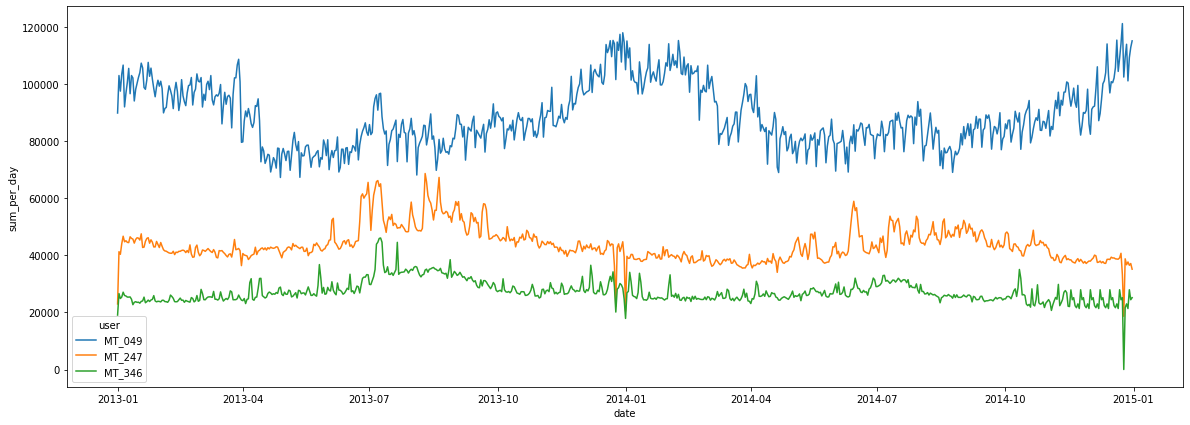

In [ ]:
# look at sample after feature engineering 

sample_df_feat = df_day_feat[df_day_feat.user.isin(selected_users)]

plt.figure(figsize=(20,7))
sns.lineplot(data=sample_df_feat, x="date", y="sum_per_day", hue="user")

## Revised ARIMA Model

In [ ]:
df_day_feat

,user,date,sum_per_day,std_per_day,overall_mean,overall_std,feat_day_std,feat_one_day_lag,feat_one_week_lag,feat_one_month_lag,...,feat_month,feat_day,day_of_week,feat_Mon,feat_Tue,feat_Wed,feat_Thr,feat_Fri,feat_Sat,feat_Sun
0,MT_001,2013-01-01,2.182741e+02,0.001697,566.267992,519.489646,0.001697,2.208122e+02,1.598985e+02,1.865482e+02,...,1,1,1,0,1,0,0,0,0,0
1,MT_001,2013-01-02,2.131980e+02,0.001585,566.267992,519.489646,0.001585,2.182741e+02,2.461929e+02,2.271574e+02,...,1,2,2,0,0,1,0,0,0,0
2,MT_001,2013-01-03,3.895939e+02,0.008541,566.267992,519.489646,0.008541,2.131980e+02,1.789340e+02,2.817259e+02,...,1,3,3,0,0,0,1,0,0,0
3,MT_001,2013-01-04,3.883249e+02,0.009533,566.267992,519.489646,0.009533,3.895939e+02,1.827411e+02,3.667513e+02,...,1,4,4,0,0,0,0,1,0,0
4,MT_001,2013-01-05,2.043147e+02,0.001565,566.267992,519.489646,0.001565,3.883249e+02,2.284264e+02,2.842640e+02,...,1,5,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243815,MT_370,2014-12-27,1.439351e+06,0.001433,825567.930396,867304.410595,0.001433,1.200378e+06,1.683730e+06,1.667081e+06,...,12,27,5,0,0,0,0,0,1,0
243816,MT_370,2014-12-28,1.556000e+06,0.002082,825567.930396,867304.410595,0.002082,1.439351e+06,1.683243e+06,1.705568e+06,...,12,28,6,0,0,0,0,0,0,1
243817,MT_370,2014-12-29,1.805676e+06,0.001912,825567.930396,867304.410595,0.001912,1.556000e+06,1.741027e+06,1.641135e+06,...,12,29,0,1,0,0,0,0,0,0
243818,MT_370,2014-12-30,1.867514e+06,0.001377,825567.930396,867304.410595,0.001377,1.805676e+06,1.583622e+06,1.684486e+06,...,12,30,1,0,1,0,0,0,0,0


In [ ]:
user_list = set(df_day_feat['user'].tolist())
print(user_list, "\n", len(user_list))

{'MT_008', 'MT_104', 'MT_006', 'MT_219', 'MT_370', 'MT_140', 'MT_263', 'MT_357', 'MT_205', 'MT_143', 'MT_043', 'MT_307', 'MT_029', 'MT_167', 'MT_146', 'MT_097', 'MT_280', 'MT_345', 'MT_090', 'MT_093', 'MT_300', 'MT_270', 'MT_114', 'MT_366', 'MT_304', 'MT_303', 'MT_137', 'MT_125', 'MT_236', 'MT_240', 'MT_058', 'MT_064', 'MT_009', 'MT_251', 'MT_216', 'MT_332', 'MT_095', 'MT_182', 'MT_069', 'MT_075', 'MT_157', 'MT_365', 'MT_324', 'MT_144', 'MT_212', 'MT_247', 'MT_001', 'MT_096', 'MT_191', 'MT_271', 'MT_349', 'MT_220', 'MT_202', 'MT_297', 'MT_198', 'MT_087', 'MT_128', 'MT_135', 'MT_156', 'MT_060', 'MT_070', 'MT_020', 'MT_249', 'MT_313', 'MT_294', 'MT_130', 'MT_356', 'MT_046', 'MT_168', 'MT_042', 'MT_265', 'MT_204', 'MT_261', 'MT_287', 'MT_355', 'MT_045', 'MT_291', 'MT_138', 'MT_059', 'MT_024', 'MT_299', 'MT_197', 'MT_129', 'MT_248', 'MT_315', 'MT_238', 'MT_239', 'MT_101', 'MT_018', 'MT_201', 'MT_081', 'MT_327', 'MT_360', 'MT_077', 'MT_054', 'MT_083', 'MT_031', 'MT_082', 'MT_002', 'MT_011',

In [ ]:
# pip install pmdarima

In [ ]:
import math
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
import warnings
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


results_dict = dict()


warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

df_arima = df_day_feat.copy()

df_arima.index = df_arima['date']
df_arima.drop(['date', 'std_per_day',	'overall_mean', 'overall_std',	'feat_day_std'], axis=1, inplace=True)

for user in tqdm(user_list):
  # print("    USER : ", user)
  tdf = df_arima[df_arima['user'] == user]
  tdf.drop('user', axis=1, inplace=True)
  
  # tdf.index = tdf['date']
  # tdf.drop(['date', 'std_per_day',	'overall_mean', 'overall_std',	'feat_day_std'], axis=1, inplace=True)
  
  # Split into dev and test
  dfsize = len(tdf)
  tdf.sort_index(inplace=True)

  X = tdf.drop('sum_per_day', axis=1)
  y = tdf['sum_per_day']

  dfsize = len(tdf)
  horizon_mapes = []

  X_train = X[:dfsize-270]
  X_test1 = X[dfsize-270:dfsize-180]
  X_test2 = X[dfsize-180:dfsize-90]
  X_test3 = X[dfsize-90:dfsize]

  y_train = y[:dfsize-270]
  y_test1 = y[dfsize-270:dfsize-180]
  y_test2 = y[dfsize-180:dfsize-90]
  y_test3 = y[dfsize-90:dfsize]

  model = auto_arima(y_train, X_train)

  p1 = model.predict(len(X_test1), X_test1)
  p2 = model.predict(len(X_test2), X_test2)
  p3 = model.predict(len(X_test3), X_test3)

  mape1 =  mean_absolute_percentage_error(y_test1, p1)
  mape2 =  mean_absolute_percentage_error(y_test2, p2)
  mape3 =  mean_absolute_percentage_error(y_test3, p3)

  horizon_mapes = [mape1, mape2, mape3]
  print("    USER : ", user, horizon_mapes)

  results_dict[user] = (model, horizon_mapes)

  0%|          | 1/334 [00:39<3:36:41, 39.04s/it]

    USER :  MT_008 [0.022736195786679257, 0.02309326154111137, 0.040239608384280284]


  1%|          | 2/334 [01:46<5:08:23, 55.73s/it]

    USER :  MT_104 [0.10506064608724637, 0.08552025698866535, 0.13473108908649614]


  1%|          | 3/334 [03:19<6:40:27, 72.59s/it]

    USER :  MT_006 [0.032419993743065666, 0.034172832566976695, 0.027779315337830505]


  1%|          | 4/334 [03:36<4:38:38, 50.66s/it]

    USER :  MT_219 [0.03662474358291352, 0.036027002741965054, 0.07295954159826551]


  1%|▏         | 5/334 [04:15<4:15:19, 46.56s/it]

    USER :  MT_370 [0.09020175575592289, 0.11521068501906635, 0.15904241894334714]


  2%|▏         | 6/334 [04:28<3:12:49, 35.27s/it]

    USER :  MT_140 [0.4564075813782804, 0.40053447874007353, 0.46634842499972357]


  2%|▏         | 7/334 [05:30<3:58:50, 43.83s/it]

    USER :  MT_263 [0.048578146118564945, 0.06595354702436063, 0.07881057822492844]


  2%|▏         | 8/334 [06:50<5:00:19, 55.28s/it]

    USER :  MT_357 [0.04640517365598916, 0.05235349466898574, 0.08019781277973305]


  3%|▎         | 9/334 [08:24<6:05:40, 67.51s/it]

    USER :  MT_205 [0.03627107506800707, 0.05014292584357649, 5.581384562111817e+18]


  3%|▎         | 10/334 [09:05<5:19:37, 59.19s/it]

    USER :  MT_143 [0.0578894140081831, 0.06298051889118542, 1.0598971702930353e+18]


  3%|▎         | 11/334 [10:33<6:07:10, 68.21s/it]

    USER :  MT_043 [0.026276882513028326, 0.023517784603550765, 0.03826503853853455]


  4%|▎         | 12/334 [11:39<6:02:15, 67.50s/it]

    USER :  MT_307 [0.042181738669790456, 0.03624483684057736, 0.048509793197587386]


  4%|▍         | 13/334 [12:42<5:53:12, 66.02s/it]

    USER :  MT_029 [0.07419522271864486, 0.07344396544050814, 0.15995767569284086]


  4%|▍         | 14/334 [12:59<4:34:06, 51.40s/it]

    USER :  MT_167 [0.03573608791922307, 0.019370710208053088, 0.06641748359288382]


  4%|▍         | 15/334 [13:33<4:04:43, 46.03s/it]

    USER :  MT_146 [0.013198067861871329, 0.027953704147634196, 0.019552887237642813]


  5%|▍         | 16/334 [15:16<5:35:39, 63.33s/it]

    USER :  MT_097 [0.07369253221631598, 0.0981429216352286, 0.18704495544327762]


  5%|▌         | 17/334 [17:10<6:53:55, 78.34s/it]

    USER :  MT_280 [0.060164952862709356, 0.05319192662674077, 0.05624747261880019]


  5%|▌         | 18/334 [17:51<5:53:54, 67.20s/it]

    USER :  MT_345 [0.05426182868447461, 0.05759663391507192, 0.07539858871990643]


  6%|▌         | 19/334 [18:30<5:07:54, 58.65s/it]

    USER :  MT_090 [0.15410155103158293, 0.23844480435043194, 1.4164742633572491]


  6%|▌         | 20/334 [18:43<3:56:16, 45.15s/it]

    USER :  MT_093 [2.0265909077433606, 1.8361170207315127, 4.082518163331048]


  6%|▋         | 21/334 [19:24<3:49:00, 43.90s/it]

    USER :  MT_300 [0.02096088952250218, 0.03167301192758633, 0.060453618400811475]


  7%|▋         | 22/334 [20:11<3:53:03, 44.82s/it]

    USER :  MT_270 [0.04067561621889244, 0.06106618291319785, 0.06407505123416567]


  7%|▋         | 23/334 [20:58<3:54:52, 45.31s/it]

    USER :  MT_114 [0.10427144259260841, 0.10283131489974558, 0.10173081973198476]


  7%|▋         | 24/334 [23:18<6:21:22, 73.81s/it]

    USER :  MT_366 [0.29769987552594707, 0.27080784950822856, 0.43482261325973803]


  7%|▋         | 25/334 [25:13<7:24:13, 86.26s/it]

    USER :  MT_304 [0.030266554866894353, 0.046628291377868836, 0.10221627065464721]


  8%|▊         | 26/334 [26:21<6:54:00, 80.65s/it]

    USER :  MT_303 [0.03934464439903139, 0.03791799366609906, 0.04527041518803667]


  8%|▊         | 27/334 [27:01<5:49:58, 68.40s/it]

    USER :  MT_137 [0.029358542495365403, 0.03701952354345149, 0.05687432200949674]


  8%|▊         | 28/334 [27:43<5:09:03, 60.60s/it]

    USER :  MT_125 [0.035654552082751076, 0.03291946219704053, 0.12988855719212408]


  9%|▊         | 29/334 [28:55<5:24:52, 63.91s/it]

    USER :  MT_236 [0.04648255523827339, 0.04253577103602467, 1.7850342281638986e+18]


  9%|▉         | 30/334 [29:57<5:20:59, 63.35s/it]

    USER :  MT_240 [0.03871040366938817, 0.12467857532495605, 0.10552705876493801]


  9%|▉         | 31/334 [30:14<4:09:21, 49.38s/it]

    USER :  MT_058 [0.030692794674969427, 0.03280622833889312, 0.05076261798241878]


 10%|▉         | 32/334 [30:24<3:09:30, 37.65s/it]

    USER :  MT_064 [0.019006672100738822, 0.022669520758614992, 2.390272129130311e+19]


 10%|▉         | 33/334 [30:36<2:30:27, 29.99s/it]

    USER :  MT_009 [0.07346706880246559, 0.05646436355522084, 0.055844641645722455]


 10%|█         | 34/334 [31:20<2:50:48, 34.16s/it]

    USER :  MT_251 [0.03435903427048244, 0.08194488960171693, 0.12654110031672144]


 10%|█         | 35/334 [33:00<4:28:47, 53.94s/it]

    USER :  MT_216 [0.03672177996046885, 0.026166017511506882, 0.053401597381735395]


 11%|█         | 36/334 [33:37<4:03:21, 49.00s/it]

    USER :  MT_332 [0.17009219839798786, 0.22198587786167642, 0.32667700893626306]


 11%|█         | 37/334 [34:22<3:55:30, 47.58s/it]

    USER :  MT_095 [0.21757900638856267, 0.27705677065088097, 0.23177199292144215]


 11%|█▏        | 38/334 [35:46<4:48:58, 58.58s/it]

    USER :  MT_182 [0.04747365772747871, 0.026109505165109344, 0.048409192537712434]


 12%|█▏        | 39/334 [36:57<5:06:32, 62.35s/it]

    USER :  MT_069 [0.028095393681930352, 0.03306928739325596, 0.043259407213646864]


 12%|█▏        | 40/334 [37:12<3:55:24, 48.04s/it]

    USER :  MT_075 [0.030165361961917755, 0.025147573879893963, 0.03351115883970698]


 12%|█▏        | 41/334 [38:41<4:55:42, 60.55s/it]

    USER :  MT_157 [0.02779746044843518, 0.040557237327834304, 0.07284431327375374]


 13%|█▎        | 42/334 [39:40<4:52:04, 60.02s/it]

    USER :  MT_365 [0.11652499877529787, 0.21154233139086492, 0.11149221863847583]


 13%|█▎        | 43/334 [41:17<5:44:58, 71.13s/it]

    USER :  MT_324 [0.030368182117728133, 0.06865994458431622, 0.05883451209410314]


 13%|█▎        | 44/334 [41:57<4:58:07, 61.68s/it]

    USER :  MT_144 [0.01503509338289743, 0.01905054114728854, 0.025058123892980327]


 13%|█▎        | 45/334 [43:18<5:24:26, 67.36s/it]

    USER :  MT_212 [0.0349787060118897, 0.02927716348080893, 0.044077557151432696]


 14%|█▍        | 46/334 [44:42<5:48:12, 72.55s/it]

    USER :  MT_247 [0.03883373122418342, 0.04644661295191695, 0.07191748873088605]


 14%|█▍        | 47/334 [46:24<6:29:44, 81.48s/it]

    USER :  MT_001 [0.5265028721586081, 0.47453397155906774, 0.626566108451534]


 14%|█▍        | 48/334 [47:22<5:53:36, 74.18s/it]

    USER :  MT_096 [0.062125788745511716, 0.0718591665947354, 0.13012980020831538]


 15%|█▍        | 49/334 [48:23<5:34:34, 70.44s/it]

    USER :  MT_191 [0.032917735434708786, 0.04854409122187289, 0.03925631957643896]


 15%|█▍        | 50/334 [49:06<4:54:35, 62.24s/it]

    USER :  MT_271 [0.03220723894361444, 0.034961591824217465, 0.036543653723919725]


 15%|█▌        | 51/334 [49:20<3:45:08, 47.73s/it]

    USER :  MT_349 [0.06504277927639873, 0.07092774467260732, 0.07160467824564694]


 16%|█▌        | 52/334 [50:33<4:19:05, 55.13s/it]

    USER :  MT_220 [0.035559824771899694, 0.04040529864025604, 0.07398781579127843]


 16%|█▌        | 53/334 [51:35<4:28:30, 57.33s/it]

    USER :  MT_202 [0.04670061006694928, 0.04743747846454663, 0.07266614961764127]


 16%|█▌        | 54/334 [52:17<4:05:33, 52.62s/it]

    USER :  MT_297 [0.04614816100704785, 0.04538366519019506, 0.07826760920144862]


 16%|█▋        | 55/334 [52:58<3:48:46, 49.20s/it]

    USER :  MT_198 [0.04768892847650207, 0.08540676654390437, 0.13312661049824046]


 17%|█▋        | 56/334 [53:39<3:36:08, 46.65s/it]

    USER :  MT_087 [0.03294226506491706, 0.03477669858328813, 0.06049490243399307]


 17%|█▋        | 57/334 [54:14<3:18:55, 43.09s/it]

    USER :  MT_128 [0.07398834614045156, 0.11293793180571934, 0.22401425343530773]


 17%|█▋        | 58/334 [56:03<4:50:23, 63.13s/it]

    USER :  MT_135 [0.032676224835692255, 0.04498323482182276, 0.049207336450985004]


 18%|█▊        | 59/334 [56:14<3:37:04, 47.36s/it]

    USER :  MT_156 [0.08620454933495295, 0.06873188199353247, 0.13295597660340258]


 18%|█▊        | 60/334 [56:25<2:46:09, 36.39s/it]

    USER :  MT_060 [0.029457655508273343, 0.04135915376869057, 0.04401299565903487]


 18%|█▊        | 61/334 [57:57<4:02:14, 53.24s/it]

    USER :  MT_070 [0.03119244438709584, 0.03759148655616169, 0.030909068268951245]


 19%|█▊        | 62/334 [58:13<3:10:49, 42.09s/it]

    USER :  MT_020 [0.05179973306909994, 0.0497365817496568, 0.06714913050311111]


 19%|█▉        | 63/334 [58:31<2:37:33, 34.89s/it]

    USER :  MT_249 [0.026148756412263094, 0.02451312546560659, 0.06418204795548335]


 19%|█▉        | 64/334 [59:20<2:55:50, 39.08s/it]

    USER :  MT_313 [0.04280552711905257, 0.06989227545594137, 2.6201282235386895e+18]


 19%|█▉        | 65/334 [1:00:37<3:46:14, 50.46s/it]

    USER :  MT_294 [0.05636604114345149, 0.034644827896458244, 0.06514829358123067]


 20%|█▉        | 66/334 [1:00:50<2:55:09, 39.22s/it]

    USER :  MT_130 [0.15364501733136465, 0.1547507221986701, 0.2025401173665031]


 20%|██        | 67/334 [1:01:03<2:19:20, 31.31s/it]

    USER :  MT_356 [0.2051285389101657, 0.15176240610178293, 0.16726293440567966]


 20%|██        | 68/334 [1:01:45<2:33:06, 34.53s/it]

    USER :  MT_046 [0.033761556757310594, 0.039574546733976666, 0.04418256480380108]


 21%|██        | 69/334 [1:02:51<3:14:18, 44.00s/it]

    USER :  MT_168 [0.04686375869986208, 0.041968881200014026, 0.0759361000008804]


 21%|██        | 70/334 [1:02:58<2:24:34, 32.86s/it]

    USER :  MT_042 [0.027386910307734734, 0.034080056602622116, 0.03750693177102082]


 21%|██▏       | 71/334 [1:04:27<3:37:35, 49.64s/it]

    USER :  MT_265 [0.027376376679190066, 0.0310422084623112, 0.08186496910625037]


 22%|██▏       | 72/334 [1:05:08<3:25:55, 47.16s/it]

    USER :  MT_204 [0.055175183175812076, 0.047808313543551785, 0.06766511037236718]


 22%|██▏       | 73/334 [1:05:55<3:23:49, 46.85s/it]

    USER :  MT_261 [0.03540013965609689, 0.08020818945896104, 0.10423389116394174]


 22%|██▏       | 74/334 [1:06:57<3:43:06, 51.48s/it]

    USER :  MT_287 [0.039185897376544494, 0.05576758220665077, 0.07695692675014068]


 22%|██▏       | 75/334 [1:08:13<4:14:01, 58.85s/it]

    USER :  MT_355 [0.05868173845951009, 0.04082264944574943, 0.05403856450171894]


 23%|██▎       | 76/334 [1:09:52<5:05:02, 70.94s/it]

    USER :  MT_045 [0.16186702768355501, 0.15950244437942246, 0.17772974439655093]


 23%|██▎       | 77/334 [1:10:35<4:28:29, 62.68s/it]

    USER :  MT_291 [0.030202856558760063, 0.07648989764974294, 0.06923865179406788]


 23%|██▎       | 78/334 [1:10:52<3:28:42, 48.92s/it]

    USER :  MT_138 [0.032494239145308544, 0.06829021359598525, 0.1491946409282218]


 24%|██▎       | 79/334 [1:11:07<2:44:55, 38.80s/it]

    USER :  MT_059 [0.036446308494032145, 0.0328619354465365, 0.06103472388828549]


 24%|██▍       | 80/334 [1:11:23<2:15:00, 31.89s/it]

    USER :  MT_024 [0.027171683458197197, 0.03038137673368221, 0.05810210091686356]


 24%|██▍       | 81/334 [1:13:28<4:12:16, 59.83s/it]

    USER :  MT_299 [0.05281062054226587, 0.07041294232691708, 0.07392220466830904]


 25%|██▍       | 82/334 [1:14:11<3:50:10, 54.80s/it]

    USER :  MT_197 [0.0391429126663508, 0.04621037449704327, 0.04449939960416938]


 25%|██▍       | 83/334 [1:14:57<3:38:18, 52.18s/it]

    USER :  MT_129 [0.19783175846657067, 0.11854095691693947, 0.039991470893248025]


 25%|██▌       | 84/334 [1:16:17<4:11:58, 60.48s/it]

    USER :  MT_248 [0.04295619982486124, 0.04433057998888794, 0.05967539503850325]


 25%|██▌       | 85/334 [1:17:03<3:52:58, 56.14s/it]

    USER :  MT_315 [0.02855918839064548, 0.03094061500482861, 0.057798224262783644]


 26%|██▌       | 86/334 [1:18:19<4:16:22, 62.03s/it]

    USER :  MT_238 [0.033238709157836555, 0.0637228156308868, 0.06396481351034003]


 26%|██▌       | 87/334 [1:20:00<5:03:51, 73.81s/it]

    USER :  MT_239 [0.03490516250950275, 0.0835110681250917, 0.07811924566551279]


 26%|██▋       | 88/334 [1:21:00<4:45:21, 69.60s/it]

    USER :  MT_101 [0.029831314253760274, 0.02202477739716907, 0.05633821523480035]


 27%|██▋       | 89/334 [1:22:46<5:28:43, 80.50s/it]

    USER :  MT_018 [0.04892852117083053, 0.045923557277215386, 0.05355541020698917]


 27%|██▋       | 90/334 [1:23:39<4:54:02, 72.31s/it]

    USER :  MT_201 [0.06428792985904305, 0.05823280476430251, 0.08906602424209922]


 27%|██▋       | 91/334 [1:25:11<5:16:35, 78.17s/it]

    USER :  MT_081 [0.03009368382261905, 0.036984380350078276, 0.03859172699491042]


 28%|██▊       | 92/334 [1:26:28<5:13:51, 77.82s/it]

    USER :  MT_327 [0.04798956579338385, 0.027761964557797926, 0.12068906091240127]


 28%|██▊       | 93/334 [1:27:48<5:15:40, 78.59s/it]

    USER :  MT_360 [0.04541355030128325, 0.04308147872477443, 0.08707805922590853]


 28%|██▊       | 94/334 [1:28:05<4:00:00, 60.00s/it]

    USER :  MT_077 [0.0635235552324029, 0.0760984935855177, 0.09095596678684313]


 28%|██▊       | 95/334 [1:29:26<4:23:36, 66.18s/it]

    USER :  MT_054 [0.016909510780356667, 0.019261878334188985, 0.027987032845855724]


 29%|██▊       | 96/334 [1:30:10<3:57:11, 59.80s/it]

    USER :  MT_083 [0.015390209487607776, 0.020967949878080462, 0.034570597124040287]


 29%|██▉       | 97/334 [1:30:30<3:07:52, 47.56s/it]

    USER :  MT_031 [0.025874155721051607, 0.030171474960254536, 0.045864998138153416]


 29%|██▉       | 98/334 [1:30:46<2:29:56, 38.12s/it]

    USER :  MT_082 [0.022262144802569713, 0.018587908957441356, 0.025157440988787732]


 30%|██▉       | 99/334 [1:31:28<2:34:13, 39.38s/it]

    USER :  MT_002 [0.03022288373982024, 0.023198142618851263, 0.02595469218921142]


 30%|██▉       | 100/334 [1:32:11<2:38:16, 40.59s/it]

    USER :  MT_011 [0.030311601185279227, 0.03091959427351132, 0.033237970802449876]


 30%|███       | 101/334 [1:33:33<3:25:44, 52.98s/it]

    USER :  MT_022 [0.05460387640200023, 0.06579578321812357, 0.10045168515100521]


 31%|███       | 102/334 [1:35:03<4:07:12, 63.93s/it]

    USER :  MT_314 [0.03893111923180908, 0.05253271819194616, 0.03908141204471948]


 31%|███       | 103/334 [1:36:12<4:11:53, 65.42s/it]

    USER :  MT_088 [0.07472908523664619, 0.11998427410240596, 0.1372565767737328]


 31%|███       | 104/334 [1:36:26<3:12:19, 50.17s/it]

    USER :  MT_171 [0.019409877429247817, 0.023519027163284575, 0.04777201085478881]


 31%|███▏      | 105/334 [1:37:09<3:02:41, 47.87s/it]

    USER :  MT_277 [0.050277749110295145, 0.0412234047003018, 0.050513406700422224]


 32%|███▏      | 106/334 [1:38:05<3:11:32, 50.40s/it]

    USER :  MT_293 [0.02907142812053946, 0.03737209659135544, 0.0851092367304827]


 32%|███▏      | 107/334 [1:38:55<3:10:14, 50.29s/it]

    USER :  MT_295 [0.05804247070532982, 0.04634535722354471, 0.09433186306092539]


 32%|███▏      | 108/334 [1:39:56<3:21:20, 53.45s/it]

    USER :  MT_359 [0.048520205026908084, 0.22962413487267508, 0.15715134539773717]


 33%|███▎      | 109/334 [1:41:22<3:57:02, 63.21s/it]

    USER :  MT_036 [0.15669336505850787, 0.16513302131227928, 0.5199366876467257]


 33%|███▎      | 110/334 [1:42:45<4:17:58, 69.10s/it]

    USER :  MT_333 [0.043034073182578694, 0.0708221956040973, 1.2558236751452961e+18]


 33%|███▎      | 111/334 [1:43:29<3:49:27, 61.74s/it]

    USER :  MT_234 [0.041963630031212826, 0.03295531423513715, 0.06071096770695371]


 34%|███▎      | 112/334 [1:44:16<3:31:59, 57.29s/it]

    USER :  MT_226 [0.05522477549649032, 0.08547037171848776, 0.09843713171579536]


 34%|███▍      | 113/334 [1:44:31<2:43:39, 44.43s/it]

    USER :  MT_055 [0.033213705083408214, 0.03302301503179382, 0.057873250104160265]


 34%|███▍      | 114/334 [1:45:31<3:00:41, 49.28s/it]

    USER :  MT_350 [0.12253880185168539, 0.07616580586346225, 0.21602196720689076]


 34%|███▍      | 115/334 [1:45:44<2:20:14, 38.42s/it]

    USER :  MT_139 [0.0602927337547972, 0.08178326816845148, 0.0811927477648257]


 35%|███▍      | 116/334 [1:46:24<2:20:58, 38.80s/it]

    USER :  MT_348 [0.4726156096140302, 0.5308894303986036, 0.6817499736036434]


 35%|███▌      | 117/334 [1:47:27<2:46:34, 46.06s/it]

    USER :  MT_206 [0.05179815055606283, 0.046015023980496984, 0.06877299262696668]


 35%|███▌      | 118/334 [1:48:07<2:39:01, 44.17s/it]

    USER :  MT_259 [0.03584944012935873, 0.04657786409282236, 0.05306662266108116]


 36%|███▌      | 119/334 [1:49:09<2:57:28, 49.53s/it]

    USER :  MT_253 [0.036039267844213616, 0.02974721002433979, 0.09663216026795386]


 36%|███▌      | 120/334 [1:50:29<3:29:16, 58.68s/it]

    USER :  MT_007 [0.35813819109916284, 0.49310479609703056, 0.6809785894607655]


 36%|███▌      | 121/334 [1:50:43<2:40:36, 45.24s/it]

    USER :  MT_066 [0.04316498823233698, 0.05499359831591241, 0.0440235059133957]


 37%|███▋      | 122/334 [1:50:52<2:01:52, 34.49s/it]

    USER :  MT_136 [0.08231361922172055, 0.07345296205637626, 2.1821113736134333e+18]


 37%|███▋      | 123/334 [1:52:26<3:03:48, 52.27s/it]

    USER :  MT_288 [0.16760941833442994, 0.2548789118017799, 2.4185391443080507e+19]


 37%|███▋      | 124/334 [1:53:28<3:13:33, 55.30s/it]

    USER :  MT_233 [0.047015627614127385, 0.03628265734500692, 0.06207627003835401]


 37%|███▋      | 125/334 [1:54:51<3:41:22, 63.55s/it]

    USER :  MT_187 [0.05397358708716316, 0.12178122914637576, 0.068637168750946]


 38%|███▊      | 126/334 [1:55:01<2:44:56, 47.58s/it]

    USER :  MT_346 [0.08037145209887622, 0.0906335035929855, 3.590022382652978e+18]


 38%|███▊      | 127/334 [1:56:49<3:46:28, 65.65s/it]

    USER :  MT_330 [0.04309593180995427, 0.030375863582946826, 0.05552820252029159]


 38%|███▊      | 128/334 [1:59:25<5:18:35, 92.79s/it]

    USER :  MT_134 [0.12690251310512649, 0.1001998925985844, 0.3920172265952673]


 39%|███▊      | 129/334 [2:00:25<4:43:07, 82.87s/it]

    USER :  MT_323 [0.049846722054598495, 0.037998016297175426, 0.10541317754854096]


 39%|███▉      | 130/334 [2:01:26<4:19:52, 76.43s/it]

    USER :  MT_211 [0.07550509317773328, 0.04858133862188572, 0.07931658566811607]


 39%|███▉      | 131/334 [2:03:04<4:40:23, 82.87s/it]

    USER :  MT_174 [0.04393231920901604, 0.050482868702793865, 2.1629468297687404e+18]


 40%|███▉      | 132/334 [2:03:39<3:50:48, 68.56s/it]

    USER :  MT_142 [0.09843971858162652, 0.05103729005122135, 0.0719815353862912]


 40%|███▉      | 133/334 [2:04:18<3:19:31, 59.56s/it]

    USER :  MT_339 [0.0671984531033522, 0.04979553043397734, 0.07418650158725287]


 40%|████      | 134/334 [2:05:26<3:27:14, 62.17s/it]

    USER :  MT_127 [1.604789497532389, 1.3803599995462479, 87.09114529920637]


 40%|████      | 135/334 [2:05:38<2:35:35, 46.91s/it]

    USER :  MT_148 [0.012564042674369287, 0.01800777621442584, 0.02129769630717597]


 41%|████      | 136/334 [2:06:42<2:52:20, 52.23s/it]

    USER :  MT_245 [0.029420475595564786, 0.03779685186918145, 0.04101711488524269]


 41%|████      | 137/334 [2:08:11<3:27:08, 63.09s/it]

    USER :  MT_353 [0.04168476002230746, 0.022057671759435526, 0.06164664051961481]


 41%|████▏     | 138/334 [2:09:40<3:52:03, 71.04s/it]

    USER :  MT_180 [0.07126679296460456, 0.0897007637827206, 0.13229829668735074]


 42%|████▏     | 139/334 [2:10:26<3:26:24, 63.51s/it]

    USER :  MT_014 [0.02874622618102034, 0.05018838425166021, 0.08302002797080742]


 42%|████▏     | 140/334 [2:11:06<3:02:18, 56.38s/it]

    USER :  MT_162 [0.07053388652362357, 0.08331649975449375, 0.19754459553172019]


 42%|████▏     | 141/334 [2:11:22<2:22:41, 44.36s/it]

    USER :  MT_065 [0.027500188049775675, 0.0380527940762704, 0.036025212395124864]


 43%|████▎     | 142/334 [2:12:28<2:42:34, 50.81s/it]

    USER :  MT_231 [0.03845292353281977, 0.03374890739785977, 0.12047186448283174]


 43%|████▎     | 143/334 [2:13:11<2:33:53, 48.35s/it]

    USER :  MT_040 [0.06567517734019399, 0.06518194064909315, 0.07404468411507173]


 43%|████▎     | 144/334 [2:14:02<2:35:59, 49.26s/it]

    USER :  MT_301 [0.029073589889723115, 0.025423528534162628, 0.04529019508699113]


 43%|████▎     | 145/334 [2:14:20<2:05:56, 39.98s/it]

    USER :  MT_056 [0.020044779146008055, 0.0235967858450941, 0.025279075646991063]


 44%|████▎     | 146/334 [2:15:00<2:04:56, 39.88s/it]

    USER :  MT_336 [0.08500234911674923, 0.0625533516670209, 1.98783212588103e+18]


 44%|████▍     | 147/334 [2:15:42<2:05:49, 40.37s/it]

    USER :  MT_177 [0.03156431899416428, 0.050838575264106775, 0.05860629048820903]


 44%|████▍     | 148/334 [2:16:33<2:15:46, 43.80s/it]

    USER :  MT_016 [0.02948897786515289, 0.03872437698933485, 0.07721121901696251]


 45%|████▍     | 149/334 [2:16:50<1:50:17, 35.77s/it]

    USER :  MT_005 [0.054109890400836615, 0.045891773029241405, 0.036375894025019284]


 45%|████▍     | 150/334 [2:17:57<2:18:03, 45.02s/it]

    USER :  MT_218 [0.04373334486081237, 0.02822330564611343, 0.06051194013357381]


 45%|████▌     | 151/334 [2:18:11<1:48:49, 35.68s/it]

    USER :  MT_230 [0.034458260740536845, 0.028635456132518663, 0.06924680446429697]


 46%|████▌     | 152/334 [2:18:51<1:52:08, 36.97s/it]

    USER :  MT_019 [0.036048769290449915, 0.044228577499495256, 0.048028921497320194]


 46%|████▌     | 153/334 [2:20:11<2:30:38, 49.94s/it]

    USER :  MT_023 [0.052617798847026526, 0.043144978089314806, 1.7413164930137248e+17]


 46%|████▌     | 154/334 [2:20:51<2:21:01, 47.01s/it]

    USER :  MT_159 [0.20767284639469763, 0.2585030504932907, 0.33797503886267105]


 46%|████▋     | 155/334 [2:21:35<2:17:00, 45.93s/it]

    USER :  MT_320 [0.031722712377306096, 0.027266161611772536, 0.05921670444162542]


 47%|████▋     | 156/334 [2:22:17<2:13:27, 44.98s/it]

    USER :  MT_343 [0.07246172227297036, 0.05154855561389594, 0.09292780530135746]


 47%|████▋     | 157/334 [2:22:58<2:08:52, 43.69s/it]

    USER :  MT_213 [0.03547029601840704, 0.03532980463188064, 0.05863593515393948]


 47%|████▋     | 158/334 [2:24:08<2:31:28, 51.64s/it]

    USER :  MT_021 [0.020809310945274374, 0.025593108326530816, 0.0456225807417548]


 48%|████▊     | 159/334 [2:25:18<2:46:10, 56.97s/it]

    USER :  MT_258 [0.02368403275881377, 0.06567528134444854, 0.07605524835654359]


 48%|████▊     | 160/334 [2:26:18<2:48:21, 58.06s/it]

    USER :  MT_190 [0.0657565061716395, 0.06909051598648337, 0.06611625779018485]


 48%|████▊     | 161/334 [2:26:34<2:10:57, 45.42s/it]

    USER :  MT_100 [0.07652030072535174, 0.0793499494748692, 0.14013762334599392]


 49%|████▊     | 162/334 [2:26:52<1:46:10, 37.04s/it]

    USER :  MT_032 [0.04562156790174656, 0.04572341741009864, 0.0549004953210187]


 49%|████▉     | 163/334 [2:27:47<2:01:29, 42.63s/it]

    USER :  MT_354 [0.18406646259381035, 0.06765286279987216, 0.07892447111376812]


 49%|████▉     | 164/334 [2:29:36<2:56:34, 62.32s/it]

    USER :  MT_189 [0.05416162624020428, 0.06515099389704049, 0.06666272592692157]


 49%|████▉     | 165/334 [2:30:18<2:38:52, 56.41s/it]

    USER :  MT_306 [0.027454695438871114, 0.07303940828529025, 0.09775558562971658]


 50%|████▉     | 166/334 [2:30:32<2:02:24, 43.72s/it]

    USER :  MT_089 [0.04752894790555042, 0.03897360603187264, 0.05679689446788612]


 50%|█████     | 167/334 [2:32:38<3:10:30, 68.45s/it]

    USER :  MT_338 [0.09092962146299904, 0.07614340977204187, 3.272382846245983e+18]


 50%|█████     | 168/334 [2:33:21<2:47:29, 60.54s/it]

    USER :  MT_017 [0.020537458260706305, 0.021217798325574872, 0.03122522847891145]


 51%|█████     | 169/334 [2:34:04<2:32:06, 55.31s/it]

    USER :  MT_145 [0.011807650888461647, 0.0198674673983898, 0.016592390706854827]


 51%|█████     | 170/334 [2:34:28<2:06:00, 46.10s/it]

    USER :  MT_222 [0.040339980953475345, 0.061149713248101215, 0.06272063980900654]


 51%|█████     | 171/334 [2:35:37<2:23:37, 52.87s/it]

    USER :  MT_175 [0.0479420113556486, 0.05124558976107945, 2.3002960717527598e+18]


 51%|█████▏    | 172/334 [2:37:13<2:57:29, 65.74s/it]

    USER :  MT_151 [0.09182352914288268, 0.06660524087099506, 1.4259351987660004e+18]


 52%|█████▏    | 173/334 [2:39:07<3:35:21, 80.26s/it]

    USER :  MT_199 [0.1165434120865487, 0.2152469586805564, 0.06638983541318995]


 52%|█████▏    | 174/334 [2:39:48<3:03:00, 68.63s/it]

    USER :  MT_328 [0.050153810739418006, 0.04775612160565779, 0.04928609329176332]


 52%|█████▏    | 175/334 [2:40:00<2:16:36, 51.55s/it]

    USER :  MT_309 [0.030451564376774543, 0.026363453573665898, 0.04949848131690157]


 53%|█████▎    | 176/334 [2:40:39<2:06:07, 47.89s/it]

    USER :  MT_103 [0.05484583933234545, 0.059004687839388545, 0.09332461017185735]


 53%|█████▎    | 177/334 [2:41:20<1:59:20, 45.61s/it]

    USER :  MT_147 [0.014871092312181663, 0.02275732458282013, 0.015536775779260102]


 53%|█████▎    | 178/334 [2:43:23<2:59:30, 69.04s/it]

    USER :  MT_105 [0.09322924724107569, 0.12443598509308612, 0.18664671972499464]


 54%|█████▎    | 179/334 [2:44:27<2:53:53, 67.31s/it]

    USER :  MT_246 [0.045248318060602546, 0.06772024277414133, 6.987407310104402e+18]


 54%|█████▍    | 180/334 [2:46:43<3:45:58, 88.04s/it]

    USER :  MT_010 [0.13514125208711983, 0.13000338691659405, 0.11167881702450634]


 54%|█████▍    | 181/334 [2:47:48<3:27:07, 81.23s/it]

    USER :  MT_161 [0.036041885260199094, 0.029724198953831018, 0.03789122882038118]


 54%|█████▍    | 182/334 [2:48:42<3:04:30, 72.83s/it]

    USER :  MT_208 [0.032078882365183595, 0.03760285013754994, 0.05359000052437599]


 55%|█████▍    | 183/334 [2:48:54<2:17:54, 54.80s/it]

    USER :  MT_364 [0.04150193067557054, 0.06342832566540353, 0.13679084674326714]


 55%|█████▌    | 184/334 [2:50:34<2:50:31, 68.21s/it]

    USER :  MT_254 [0.03868590002602083, 0.047643143368122746, 0.05370898268169477]


 55%|█████▌    | 185/334 [2:51:36<2:44:30, 66.25s/it]

    USER :  MT_061 [0.029228558125757833, 0.045414111296665303, 0.05177222792749607]


 56%|█████▌    | 186/334 [2:52:17<2:24:57, 58.77s/it]

    USER :  MT_034 [0.027275309821228822, 0.06305364751559207, 0.059701976295575124]


 56%|█████▌    | 187/334 [2:54:13<3:06:30, 76.12s/it]

    USER :  MT_250 [0.038397648953859526, 0.1114552180231517, 0.05118263382443596]


 56%|█████▋    | 188/334 [2:54:30<2:21:46, 58.26s/it]

    USER :  MT_368 [0.04220944764789951, 0.03367870283716621, 0.12470401867817699]


 57%|█████▋    | 189/334 [2:56:02<2:45:01, 68.29s/it]

    USER :  MT_057 [0.045829639168282074, 0.047088179034195786, 4.157227564396146e+17]


 57%|█████▋    | 190/334 [2:56:44<2:25:06, 60.46s/it]

    USER :  MT_237 [0.026015085350581876, 0.061484872700012023, 0.07701468354834394]


 57%|█████▋    | 191/334 [2:57:56<2:32:38, 64.04s/it]

    USER :  MT_084 [0.05888126041542726, 0.04941499913411597, 0.07127635208127477]


 57%|█████▋    | 192/334 [2:58:35<2:13:52, 56.56s/it]

    USER :  MT_358 [0.08551903750679311, 0.07621981697114372, 0.11601252547242882]


 58%|█████▊    | 193/334 [2:59:32<2:12:43, 56.48s/it]

    USER :  MT_273 [0.03787839698536308, 0.041344160845880426, 0.06100783967166593]


 58%|█████▊    | 194/334 [2:59:48<1:43:21, 44.30s/it]

    USER :  MT_172 [0.028478876178384557, 0.02857933492835294, 0.06062101709384866]


 58%|█████▊    | 195/334 [3:01:27<2:20:33, 60.67s/it]

    USER :  MT_063 [0.025476550682550284, 0.02846629164305897, 0.050503849799888235]


 59%|█████▊    | 196/334 [3:03:23<2:58:02, 77.41s/it]

    USER :  MT_195 [0.05094782712835032, 0.06354240576317796, 0.07844374661993851]


 59%|█████▉    | 197/334 [3:03:39<2:14:24, 58.87s/it]

    USER :  MT_184 [0.02076610616460278, 0.02208762173409816, 0.06238756211891829]


 59%|█████▉    | 198/334 [3:04:54<2:24:26, 63.72s/it]

    USER :  MT_225 [0.04393106340353866, 0.04392879108333427, 0.04121585814050879]


 60%|█████▉    | 199/334 [3:05:09<1:50:36, 49.16s/it]

    USER :  MT_013 [0.06527182998627666, 0.09119679069744407, 0.26695977064526005]


 60%|█████▉    | 200/334 [3:05:49<1:43:32, 46.36s/it]

    USER :  MT_363 [0.05046454870391891, 0.04414299184127852, 0.08954499189996244]


 60%|██████    | 201/334 [3:06:05<1:23:04, 37.48s/it]

    USER :  MT_048 [0.06716074640360867, 0.04220812342109948, 0.06117296175980089]


 60%|██████    | 202/334 [3:06:44<1:23:04, 37.76s/it]

    USER :  MT_051 [0.03560597303522043, 0.03453629919147625, 0.04482751430664992]


 61%|██████    | 203/334 [3:07:46<1:38:14, 45.00s/it]

    USER :  MT_326 [0.04388565751961023, 0.04788485296966373, 0.052188053144022445]


 61%|██████    | 204/334 [3:08:01<1:18:22, 36.17s/it]

    USER :  MT_028 [0.03487782990860291, 0.03952299028566495, 0.05276477809675092]


 61%|██████▏   | 205/334 [3:08:59<1:31:48, 42.70s/it]

    USER :  MT_367 [0.02707486424904373, 0.046910736191753254, 0.07320725257390016]


 62%|██████▏   | 206/334 [3:10:01<1:43:29, 48.51s/it]

    USER :  MT_152 [0.07051758359354553, 0.12842647235773605, 0.089683423258957]


 62%|██████▏   | 207/334 [3:11:42<2:15:36, 64.07s/it]

    USER :  MT_335 [0.1138898086445482, 0.06106045655839463, 7.566394521879046e+17]


 62%|██████▏   | 208/334 [3:12:41<2:11:28, 62.61s/it]

    USER :  MT_196 [0.050996007653983474, 0.041822474299595964, 0.05003315804027471]


 63%|██████▎   | 209/334 [3:14:02<2:22:18, 68.31s/it]

    USER :  MT_209 [0.09000102394005942, 0.09623831188105757, 0.10840803199628143]


 63%|██████▎   | 210/334 [3:15:44<2:41:34, 78.19s/it]

    USER :  MT_267 [0.0548768204640302, 0.09031568716025049, 7.522512483780531e+17]


 63%|██████▎   | 211/334 [3:16:24<2:16:51, 66.76s/it]

    USER :  MT_274 [0.03720326726477144, 0.032287461050048066, 0.05096621107728104]


 63%|██████▎   | 212/334 [3:17:29<2:14:44, 66.26s/it]

    USER :  MT_099 [0.08624858442571773, 0.057146089554019217, 0.06204429541685725]


 64%|██████▍   | 213/334 [3:18:36<2:14:13, 66.56s/it]

    USER :  MT_210 [0.031717690551333014, 0.08368419773382144, 0.06766999614005004]


 64%|██████▍   | 214/334 [3:19:17<1:57:56, 58.97s/it]

    USER :  MT_214 [0.03815475133482492, 0.03997550406315577, 0.060485843228059784]


 64%|██████▍   | 215/334 [3:20:10<1:53:21, 57.16s/it]

    USER :  MT_369 [0.031974817903162894, 0.02548918188990094, 0.026523600799246486]


 65%|██████▍   | 216/334 [3:21:18<1:58:48, 60.41s/it]

    USER :  MT_221 [0.031218394673928992, 0.05678943358165109, 0.0686376482154178]


 65%|██████▍   | 217/334 [3:21:57<1:45:21, 54.03s/it]

    USER :  MT_123 [0.08617495154496858, 8.37352233604188e+17, 1.0839106071567676e+18]


 65%|██████▌   | 218/334 [3:22:13<1:22:17, 42.56s/it]

    USER :  MT_052 [0.02595942276804767, 0.028264202849134026, 0.03964455761462967]


 66%|██████▌   | 219/334 [3:23:34<1:43:26, 53.97s/it]

    USER :  MT_200 [0.08149121570704163, 0.1356733800544535, 0.1395254354292019]


 66%|██████▌   | 220/334 [3:24:12<1:33:30, 49.22s/it]

    USER :  MT_118 [0.03923663516120366, 0.04147314050631867, 0.043048088266402454]


 66%|██████▌   | 221/334 [3:24:26<1:12:48, 38.66s/it]

    USER :  MT_310 [0.02299583483313258, 0.029006617763099672, 0.04741412553604714]


 66%|██████▋   | 222/334 [3:25:02<1:10:41, 37.87s/it]

    USER :  MT_331 [0.08198664812416002, 0.1632037609209627, 0.0727416641158999]


 67%|██████▋   | 223/334 [3:25:16<56:55, 30.77s/it]  

    USER :  MT_262 [0.03152642968810894, 0.02356219878799606, 0.03607622630964546]


 67%|██████▋   | 224/334 [3:27:09<1:41:14, 55.22s/it]

    USER :  MT_252 [0.3778875859478363, 0.20743153402242492, 0.0729679981095889]


 67%|██████▋   | 225/334 [3:27:25<1:18:57, 43.46s/it]

    USER :  MT_296 [0.02284319434115721, 0.027324175753012152, 0.04811163656342276]


 68%|██████▊   | 226/334 [3:28:45<1:37:58, 54.43s/it]

    USER :  MT_325 [0.025341665818005395, 0.06102346242411152, 0.06566359664973886]


 68%|██████▊   | 227/334 [3:29:48<1:41:53, 57.14s/it]

    USER :  MT_232 [0.03377758302029729, 0.08883428058906145, 0.09630976015569612]


 68%|██████▊   | 228/334 [3:30:42<1:39:17, 56.20s/it]

    USER :  MT_311 [0.05699443394069027, 0.02940983980730223, 0.0593100253855939]


 69%|██████▊   | 229/334 [3:31:36<1:37:10, 55.53s/it]

    USER :  MT_080 [0.039536349337868155, 0.058326362152657095, 0.0452410505581109]


 69%|██████▉   | 230/334 [3:32:11<1:25:42, 49.45s/it]

    USER :  MT_053 [0.0320148858863973, 0.033241184667277594, 0.04673549482180462]


 69%|██████▉   | 231/334 [3:33:09<1:28:54, 51.79s/it]

    USER :  MT_244 [0.02803530214789914, 0.026868641863646854, 0.044981307539357314]


 69%|██████▉   | 232/334 [3:34:03<1:29:17, 52.52s/it]

    USER :  MT_308 [0.08644848498712346, 0.1212865596546641, 0.11177843490689475]


 70%|██████▉   | 233/334 [3:35:26<1:43:42, 61.61s/it]

    USER :  MT_361 [0.061376784133017406, 0.048397577544198295, 0.05539375186799803]


 70%|███████   | 234/334 [3:36:05<1:31:36, 54.96s/it]

    USER :  MT_098 [0.03488824091327471, 0.0493359804867808, 0.050534036363720385]


 70%|███████   | 235/334 [3:36:21<1:11:25, 43.29s/it]

    USER :  MT_278 [0.024884410756083008, 0.027090053645530663, 0.07320472602082126]


 71%|███████   | 236/334 [3:37:39<1:27:32, 53.60s/it]

    USER :  MT_312 [0.04397531901493254, 0.036269830268797786, 0.08562557030256576]


 71%|███████   | 237/334 [3:39:33<1:56:13, 71.89s/it]

    USER :  MT_004 [0.03259955728429176, 0.027033718676855608, 0.02798484884575769]


 71%|███████▏  | 238/334 [3:39:50<1:28:18, 55.19s/it]

    USER :  MT_150 [0.026253667262703954, 0.04575037732772596, 0.025868626308709997]


 72%|███████▏  | 239/334 [3:40:47<1:28:20, 55.80s/it]

    USER :  MT_149 [0.026181279474302658, 0.03785607201963575, 0.050151236782078674]


 72%|███████▏  | 240/334 [3:41:02<1:08:27, 43.70s/it]

    USER :  MT_352 [0.21319686425426976, 0.11217734266082219, 0.15529042066902213]


 72%|███████▏  | 241/334 [3:42:38<1:32:08, 59.44s/it]

    USER :  MT_079 [0.05962050552047276, 0.05290228015908241, 0.05915165376808839]


 72%|███████▏  | 242/334 [3:43:17<1:21:38, 53.24s/it]

    USER :  MT_255 [0.028568075786567507, 0.03076010912133627, 0.09446675434342547]


 73%|███████▎  | 243/334 [3:43:28<1:01:15, 40.39s/it]

    USER :  MT_351 [0.06007439254458667, 0.0464922838429163, 0.08013950573839482]


 73%|███████▎  | 244/334 [3:44:24<1:07:55, 45.28s/it]

    USER :  MT_037 [0.03500067180698985, 0.04456101064192852, 0.045182278351880614]


 73%|███████▎  | 245/334 [3:45:16<1:10:09, 47.30s/it]

    USER :  MT_086 [0.030189032738111705, 0.03179573789279167, 0.041590019260101876]


 74%|███████▎  | 246/334 [3:46:01<1:08:09, 46.47s/it]

    USER :  MT_285 [0.03255806252656569, 0.04820155608956899, 0.05958265297058729]


 74%|███████▍  | 247/334 [3:47:06<1:15:26, 52.03s/it]

    USER :  MT_126 [0.045343798285446546, 0.0781873198904117, 0.12474527562522073]


 74%|███████▍  | 248/334 [3:47:43<1:08:21, 47.69s/it]

    USER :  MT_038 [0.021521489930289302, 0.03340162996061887, 0.040259948299439546]
    USER :  MT_318 [0.043881594070420485, 0.03526865702094533, 0.04445259989865501]


 75%|███████▍  | 250/334 [3:49:13<1:03:57, 45.69s/it]

    USER :  MT_283 [0.030318841634915453, 0.0361256330119251, 0.045511357040839896]


 75%|███████▌  | 251/334 [3:50:34<1:17:56, 56.34s/it]

    USER :  MT_302 [0.03492360479875223, 0.04168223237574142, 0.08154465537207828]


 75%|███████▌  | 252/334 [3:51:57<1:27:56, 64.34s/it]

    USER :  MT_316 [0.02616655307756555, 0.04599568235041682, 0.04072326248396832]


 76%|███████▌  | 253/334 [3:52:37<1:17:14, 57.21s/it]

    USER :  MT_154 [0.024201271013846035, 0.0706718896840013, 0.04279909142683316]


 76%|███████▌  | 254/334 [3:53:23<1:11:29, 53.61s/it]

    USER :  MT_260 [0.06808862173738091, 0.0561352306930125, 0.08110738476859178]


 76%|███████▋  | 255/334 [3:54:03<1:05:27, 49.71s/it]

    USER :  MT_026 [0.025655818054360496, 0.033740625445985745, 0.049550849495819886]


 77%|███████▋  | 256/334 [3:54:55<1:05:28, 50.36s/it]

    USER :  MT_329 [0.040129966207505544, 0.06729037312468268, 0.07565102961368671]


 77%|███████▋  | 257/334 [3:56:14<1:15:36, 58.92s/it]

    USER :  MT_279 [0.041274928945697065, 0.10633232058745828, 1.3702118575049227e+20]


 77%|███████▋  | 258/334 [3:56:50<1:06:05, 52.18s/it]

    USER :  MT_183 [0.03643491760034731, 0.06023429375771567, 0.06915165277957752]


 78%|███████▊  | 259/334 [3:57:52<1:08:44, 54.99s/it]

    USER :  MT_194 [0.062389753490298475, 0.15498302326768265, 0.08679319554768147]


 78%|███████▊  | 260/334 [3:59:31<1:24:08, 68.22s/it]

    USER :  MT_073 [0.0722602704008076, 0.11428685762188653, 0.1687642645212349]


 78%|███████▊  | 261/334 [4:00:39<1:22:46, 68.04s/it]

    USER :  MT_276 [0.040691200936670176, 0.030147656352414762, 0.04507258652931683]


 78%|███████▊  | 262/334 [4:02:07<1:28:47, 74.00s/it]

    USER :  MT_102 [0.06596977052589953, 0.07197396904903047, 0.05997573151089105]


 79%|███████▊  | 263/334 [4:03:12<1:24:24, 71.34s/it]

    USER :  MT_124 [0.042000972356282446, 0.040025548021410784, 0.13137416756559228]


 79%|███████▉  | 264/334 [4:04:32<1:26:29, 74.13s/it]

    USER :  MT_256 [0.03862515183832853, 0.06717312630370277, 0.057314295222643856]


 79%|███████▉  | 265/334 [4:05:54<1:27:59, 76.52s/it]

    USER :  MT_141 [0.015591119645129513, 0.013232624863142518, 0.010709016552995443]


 80%|███████▉  | 266/334 [4:06:51<1:19:53, 70.50s/it]

    USER :  MT_193 [0.06327967189216936, 0.08081956544449903, 0.08956808955413066]


 80%|███████▉  | 267/334 [4:08:15<1:23:08, 74.45s/it]

    USER :  MT_340 [0.09584050667051992, 0.11123552507128308, 0.1431648632888721]


 80%|████████  | 268/334 [4:10:26<1:40:47, 91.63s/it]

    USER :  MT_334 [0.10767308349484082, 0.0736100382322425, 7.339418257768113e+17]


 81%|████████  | 269/334 [4:11:01<1:20:55, 74.69s/it]

    USER :  MT_153 [0.02908677008237496, 0.02121847530492541, 0.04003486206785111]


 81%|████████  | 270/334 [4:11:44<1:09:19, 64.99s/it]

    USER :  MT_344 [0.06545152541287874, 0.09918956132836271, 0.13738622126694283]


 81%|████████  | 271/334 [4:12:01<53:17, 50.75s/it]  

    USER :  MT_119 [0.0832325241283253, 0.10396510892856199, 0.08006972616786832]


 81%|████████▏ | 272/334 [4:13:16<59:57, 58.03s/it]

    USER :  MT_203 [0.04217778570195068, 0.036747965707085314, 1.075574703565851]


 82%|████████▏ | 273/334 [4:13:51<51:50, 51.00s/it]

    USER :  MT_025 [0.04695426006799427, 0.04804100662613396, 0.04244819706499895]


 82%|████████▏ | 274/334 [4:15:20<1:02:31, 62.53s/it]

    USER :  MT_027 [0.031250983248483216, 0.043305019809835726, 0.03830305534753342]


 82%|████████▏ | 275/334 [4:17:17<1:17:28, 78.79s/it]

    USER :  MT_241 [0.05311382566503361, 0.038015775734615995, 0.07703299489952967]


 83%|████████▎ | 276/334 [4:17:54<1:04:04, 66.28s/it]

    USER :  MT_317 [0.047352084969509045, 0.1712847623503964, 0.1106777965628325]


 83%|████████▎ | 277/334 [4:18:52<1:00:37, 63.82s/it]

    USER :  MT_094 [0.2981534662888586, 0.26425149591082053, 0.40562536796160426]


 83%|████████▎ | 278/334 [4:19:37<54:18, 58.18s/it]  

    USER :  MT_071 [0.022877600144269133, 0.03120899392215688, 0.030272548928840775]


 84%|████████▎ | 279/334 [4:19:48<40:23, 44.07s/it]

    USER :  MT_068 [0.025511562795461462, 0.024196365624146312, 0.03201209469347898]


 84%|████████▍ | 280/334 [4:20:21<36:25, 40.48s/it]

    USER :  MT_362 [0.05758242216964448, 0.07367872757184356, 0.06387524309256123]


 84%|████████▍ | 281/334 [4:21:33<44:07, 49.96s/it]

    USER :  MT_268 [0.05134819796419703, 0.08013051688086538, 0.10335709597779287]


 84%|████████▍ | 282/334 [4:22:12<40:36, 46.86s/it]

    USER :  MT_217 [0.04036199909004113, 0.045294628557529325, 0.07248052681288844]


 85%|████████▍ | 283/334 [4:23:12<43:07, 50.74s/it]

    USER :  MT_341 [0.04425222114950214, 0.08068665497789744, 0.07582843623622056]


 85%|████████▌ | 284/334 [4:24:13<44:44, 53.69s/it]

    USER :  MT_228 [0.05102195613384111, 0.07108986467776043, 0.0812976432873726]


 85%|████████▌ | 285/334 [4:25:36<51:05, 62.55s/it]

    USER :  MT_281 [0.032515390654940274, 0.03548714874588231, 0.06762528153132401]


 86%|████████▌ | 286/334 [4:26:16<44:46, 55.97s/it]

    USER :  MT_290 [0.07999524998570966, 0.0438268589886157, 0.11179375058952168]


 86%|████████▌ | 287/334 [4:26:46<37:43, 48.16s/it]

    USER :  MT_176 [0.04363401165644542, 0.0496881172322927, 0.0578020734706105]


 86%|████████▌ | 288/334 [4:27:02<29:24, 38.35s/it]

    USER :  MT_074 [0.026080685331419946, 0.02912592636928082, 0.039748323190815976]


 87%|████████▋ | 289/334 [4:28:34<40:55, 54.56s/it]

    USER :  MT_132 [0.15970630914558245, 0.11212173425092682, 0.20502381044273868]


 87%|████████▋ | 290/334 [4:29:14<36:39, 49.98s/it]

    USER :  MT_321 [0.04175439118388149, 0.03523365341668779, 0.04998799857202281]


 87%|████████▋ | 291/334 [4:30:20<39:24, 55.00s/it]

    USER :  MT_047 [0.07083555630688747, 0.04166609677422972, 0.044123245473910375]


 87%|████████▋ | 292/334 [4:31:47<45:13, 64.61s/it]

    USER :  MT_284 [0.04966590374111456, 0.032098055835839176, 0.03173906689998697]


 88%|████████▊ | 293/334 [4:32:03<34:04, 49.87s/it]

    USER :  MT_033 [0.030906633559502794, 0.029968275216020246, 0.053089610521268156]


 88%|████████▊ | 294/334 [4:32:45<31:44, 47.62s/it]

    USER :  MT_235 [0.040817804433612374, 0.045539254681282344, 0.08936490267892218]


 88%|████████▊ | 295/334 [4:32:57<23:53, 36.76s/it]

    USER :  MT_131 [0.29234721227432486, 0.3794347918280089, 0.18351908980005469]


 89%|████████▊ | 296/334 [4:33:57<27:50, 43.95s/it]

    USER :  MT_163 [0.03418525334905667, 0.0292118136480743, 0.05285498041894052]


 89%|████████▉ | 297/334 [4:34:13<21:48, 35.36s/it]

    USER :  MT_050 [0.019341591653318342, 0.02713761372503281, 0.051076999748797425]


 89%|████████▉ | 298/334 [4:34:56<22:41, 37.83s/it]

    USER :  MT_173 [0.08604451094966868, 0.19007071636847742, 0.1088561183889538]


 90%|████████▉ | 299/334 [4:35:12<18:17, 31.36s/it]

    USER :  MT_035 [0.02953194011339474, 0.02840542011926111, 0.04386437516561229]


 90%|████████▉ | 300/334 [4:35:23<14:18, 25.24s/it]

    USER :  MT_091 [0.04692913756659875, 0.03795225751427152, 0.050271328840103414]


 90%|█████████ | 301/334 [4:36:37<21:50, 39.72s/it]

    USER :  MT_207 [0.07722623304525719, 0.08594532466767954, 0.0643948190032797]


 90%|█████████ | 302/334 [4:37:43<25:21, 47.55s/it]

    USER :  MT_292 [0.037575829698497445, 0.041031205221380734, 0.07853914408372994]


 91%|█████████ | 303/334 [4:38:45<26:53, 52.04s/it]

    USER :  MT_229 [0.03650864785751335, 0.05146642191426845, 1.083042792701927e+19]


 91%|█████████ | 304/334 [4:39:42<26:39, 53.31s/it]

    USER :  MT_272 [0.04990891425579853, 0.021205649911089485, 0.04524840041991329]


 91%|█████████▏| 305/334 [4:40:00<20:44, 42.91s/it]

    USER :  MT_076 [0.031884624152314016, 0.03565245420995418, 0.030872029991890034]


 92%|█████████▏| 306/334 [4:41:19<25:06, 53.80s/it]

    USER :  MT_215 [0.04232847643847756, 0.02237479616390487, 0.022026146531208067]


 92%|█████████▏| 307/334 [4:42:42<28:04, 62.39s/it]

    USER :  MT_266 [0.04549974858968054, 0.03819832605462983, 0.09005241642171233]


 92%|█████████▏| 308/334 [4:44:07<29:57, 69.12s/it]

    USER :  MT_062 [0.032486516539298335, 0.03453084073832364, 0.03282446146654821]


 93%|█████████▎| 309/334 [4:44:43<24:39, 59.19s/it]

    USER :  MT_342 [0.04280115211618631, 0.055644106708187493, 0.07441977146025183]


 93%|█████████▎| 310/334 [4:45:10<19:48, 49.51s/it]

    USER :  MT_257 [0.04576606508405528, 0.18968274120494386, 0.12187392312141436]


 93%|█████████▎| 311/334 [4:46:20<21:22, 55.78s/it]

    USER :  MT_319 [0.043964700695471606, 0.04184092415788347, 0.047347605980272066]


 93%|█████████▎| 312/334 [4:46:38<16:18, 44.50s/it]

    USER :  MT_155 [0.1642924891098208, 0.3087613530531828, 0.4064352603700676]


 94%|█████████▎| 313/334 [4:46:55<12:42, 36.30s/it]

    USER :  MT_158 [0.10201584909044195, 0.11313251909792531, 0.0984999588861394]


 94%|█████████▍| 314/334 [4:48:39<18:47, 56.40s/it]

    USER :  MT_044 [0.03027168908498519, 0.03186216180980919, 0.056807581113343344]


 94%|█████████▍| 315/334 [4:49:46<18:54, 59.70s/it]

    USER :  MT_275 [0.02951926561815071, 0.04157167414398548, 0.05364424874263506]


 95%|█████████▍| 316/334 [4:50:36<16:59, 56.66s/it]

    USER :  MT_243 [0.04753235564003779, 0.033215435001947485, 0.05765649484716558]


 95%|█████████▍| 317/334 [4:51:10<14:09, 49.97s/it]

    USER :  MT_164 [0.09072853506313609, 0.12261093138020333, 0.15550392415216818]


 95%|█████████▌| 318/334 [4:52:34<16:01, 60.11s/it]

    USER :  MT_269 [0.05179832915796218, 0.10695525715276848, 0.07695121344907233]


 96%|█████████▌| 319/334 [4:53:57<16:47, 67.17s/it]

    USER :  MT_227 [0.06472452026304869, 0.051905902743518986, 0.07376292017610551]


 96%|█████████▌| 320/334 [4:55:51<18:57, 81.25s/it]

    USER :  MT_282 [0.029992925485626477, 0.04014291622962017, 1.218665913313927e+18]


 96%|█████████▌| 321/334 [4:56:05<13:11, 60.88s/it]

    USER :  MT_078 [0.021033756546184904, 0.034812083294892396, 0.041625245202015]


 96%|█████████▋| 322/334 [4:56:50<11:15, 56.30s/it]

    USER :  MT_169 [0.039847156392456146, 0.051688058127407115, 0.04530231876479051]


 97%|█████████▋| 323/334 [4:57:15<08:35, 46.84s/it]

    USER :  MT_085 [0.024512409083505788, 0.027184054430949532, 0.038301148359877094]


 97%|█████████▋| 324/334 [4:57:33<06:21, 38.13s/it]

    USER :  MT_072 [0.027013962812503598, 0.035776248033684774, 0.027427599677556518]


 97%|█████████▋| 325/334 [4:58:37<06:52, 45.84s/it]

    USER :  MT_166 [0.02327694519686636, 0.05508222361009582, 0.050333036074581505]


 98%|█████████▊| 326/334 [4:59:27<06:18, 47.27s/it]

    USER :  MT_188 [0.0458439131307611, 0.10575505809746527, 5.715607493988462e+17]


 98%|█████████▊| 327/334 [5:00:52<06:48, 58.42s/it]

    USER :  MT_286 [0.059036306784808305, 0.0687236027944619, 0.07367921716098241]


 98%|█████████▊| 328/334 [5:02:27<06:57, 69.57s/it]

    USER :  MT_298 [0.03940517276534975, 0.037040658997325754, 0.033268310880760654]


 99%|█████████▊| 329/334 [5:02:35<04:14, 50.84s/it]

    USER :  MT_067 [0.031084949338897272, 0.03629331683815625, 0.04480611321511436]


 99%|█████████▉| 330/334 [5:04:13<04:20, 65.07s/it]

    USER :  MT_192 [0.06204447687396391, 0.05596157137568981, 0.0704486357888833]


 99%|█████████▉| 331/334 [5:04:28<02:30, 50.00s/it]

    USER :  MT_003 [0.025149089474679073, 0.02747428952216714, 2.4892966060067412e+16]


 99%|█████████▉| 332/334 [5:05:03<01:31, 45.54s/it]

    USER :  MT_049 [0.019397230156537385, 0.03515373399882069, 0.03696166393238617]


100%|█████████▉| 333/334 [5:05:44<00:44, 44.32s/it]

    USER :  MT_242 [0.03426627091646909, 0.041804173935547334, 0.10269545643849533]


100%|██████████| 334/334 [5:07:05<00:00, 55.17s/it]

    USER :  MT_264 [0.037350451126658725, 0.05373670930834795, 0.07349703608445386]


In [ ]:
arima_output = pd.DataFrame.from_dict(results_dict, orient='index')
arima_output

,0,1
MT_008,"ARIMA(1,0,0)(0,0,0)[0]","[0.022736195786679257, 0.02309326154111137, 0...."
MT_104,"ARIMA(1,0,1)(0,0,0)[0]","[0.10506064608724637, 0.08552025698866535, 0.1..."
MT_006,"ARIMA(2,0,2)(0,0,0)[0]","[0.032419993743065666, 0.034172832566976695, 0..."
MT_219,"ARIMA(0,0,0)(0,0,0)[0] intercept","[0.03662474358291352, 0.036027002741965054, 0...."
MT_370,"ARIMA(0,0,1)(0,0,0)[0]","[0.09020175575592289, 0.11521068501906635, 0.1..."
...,...,...
MT_192,"ARIMA(5,0,0)(0,0,0)[0]","[0.06204447687396391, 0.05596157137568981, 0.0..."
MT_003,"ARIMA(0,0,0)(0,0,0)[0]","[0.025149089474679073, 0.02747428952216714, 2...."
MT_049,"ARIMA(1,0,0)(0,0,0)[0]","[0.019397230156537385, 0.03515373399882069, 0...."
MT_242,"ARIMA(1,0,0)(0,0,0)[0]","[0.03426627091646909, 0.041804173935547334, 0...."


In [ ]:
arima_output.to_csv('arima_output.csv')

In [ ]:
arima_output.columns = ['model', 'mapes']

In [ ]:
broken_down = arima_output.apply(lambda x: x["mapes"], result_type="expand",axis=1) 
merged = arima_output.merge(broken_down, how='left', left_index=True, right_index=True)

merged.columns = ['model', 'mapes_list', 'first_3', 'middle_3', 'last_3']
merged.drop('mapes_list', inplace=True, axis=1)
display(merged)

,model,first_3,middle_3,last_3
MT_008,"ARIMA(1,0,0)(0,0,0)[0]",0.022736,0.023093,4.023961e-02
MT_104,"ARIMA(1,0,1)(0,0,0)[0]",0.105061,0.085520,1.347311e-01
MT_006,"ARIMA(2,0,2)(0,0,0)[0]",0.032420,0.034173,2.777932e-02
MT_219,"ARIMA(0,0,0)(0,0,0)[0] intercept",0.036625,0.036027,7.295954e-02
MT_370,"ARIMA(0,0,1)(0,0,0)[0]",0.090202,0.115211,1.590424e-01
...,...,...,...,...
MT_192,"ARIMA(5,0,0)(0,0,0)[0]",0.062044,0.055962,7.044864e-02
MT_003,"ARIMA(0,0,0)(0,0,0)[0]",0.025149,0.027474,2.489297e+16
MT_049,"ARIMA(1,0,0)(0,0,0)[0]",0.019397,0.035154,3.696166e-02
MT_242,"ARIMA(1,0,0)(0,0,0)[0]",0.034266,0.041804,1.026955e-01


In [ ]:
# merged.to_csv('merged.csv')

In [ ]:
filter = merged[merged['last_3'] < 110000]

print(len(filter) / len(merged))

filter.mean()

0.9221556886227545


first_3     0.070958
middle_3    0.078074
last_3      0.390979
dtype: float64

In [ ]:
filter2 = merged['last_3'].apply(lambda x: math.log(x, 10))

filter2 = filter2[filter2 > 1]

# filter2.plot.bar()

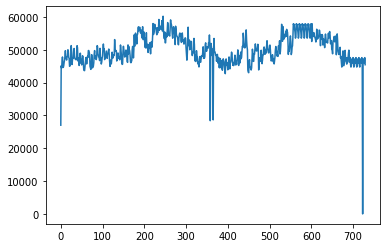

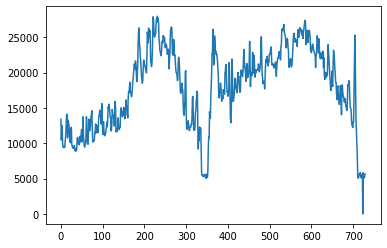

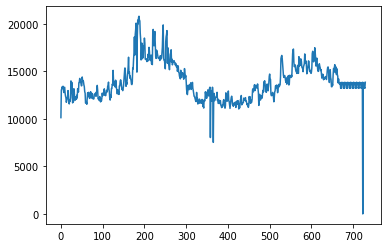

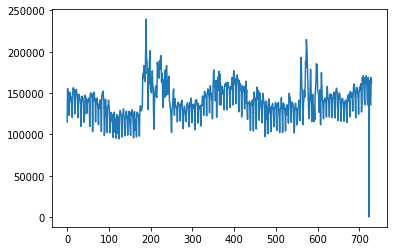

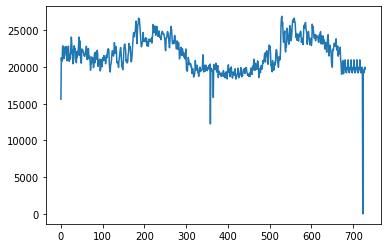

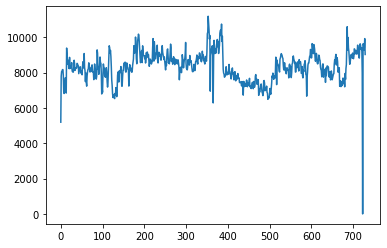

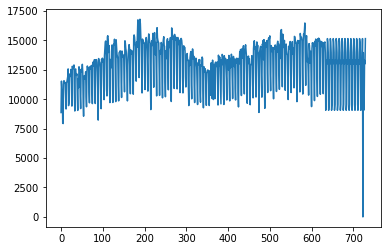

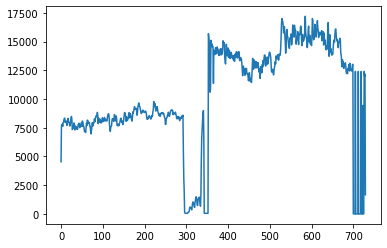

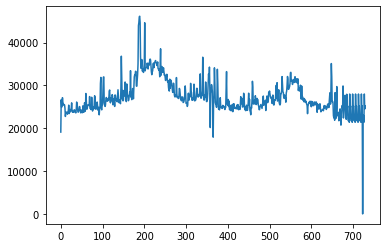

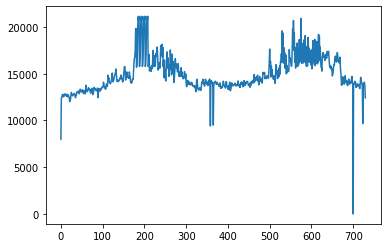

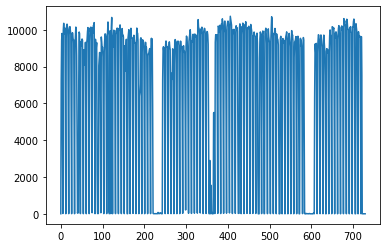

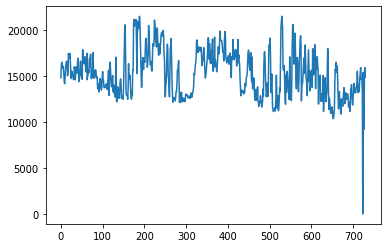

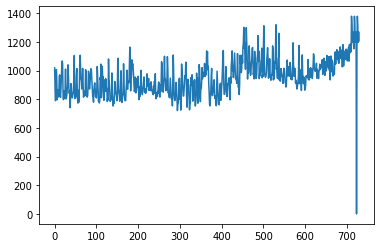

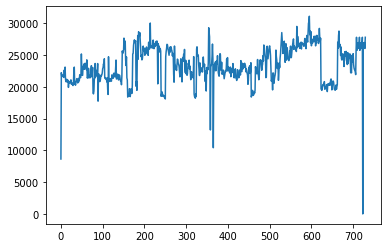

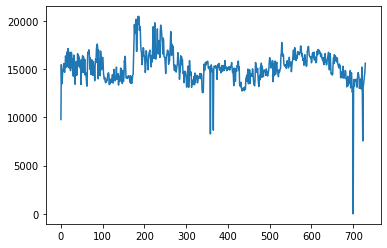

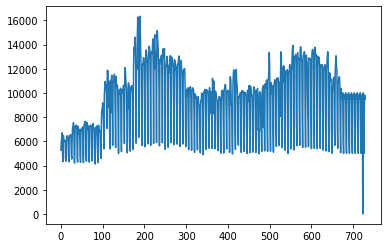

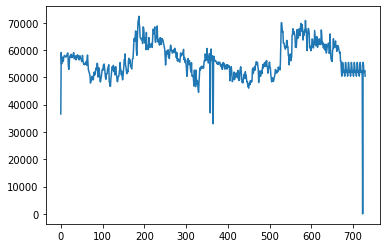

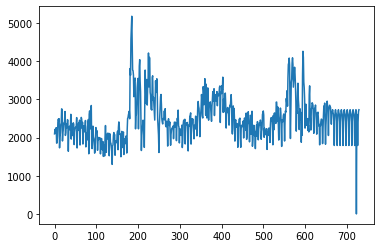

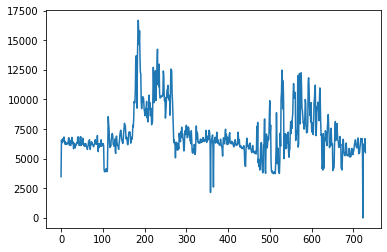

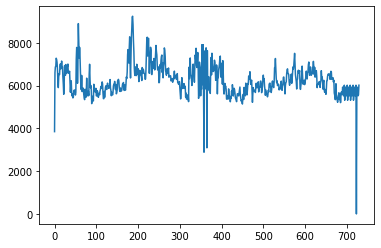

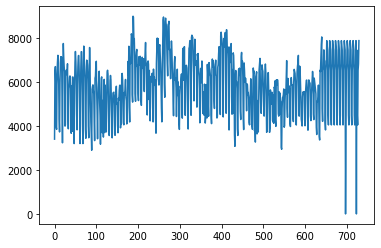

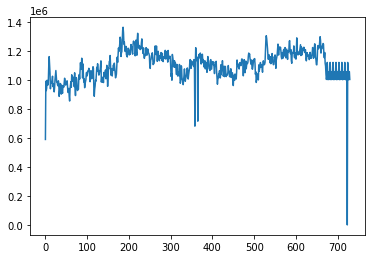

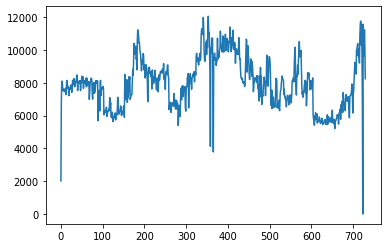

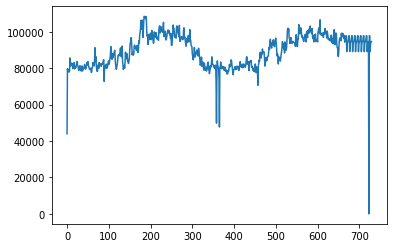

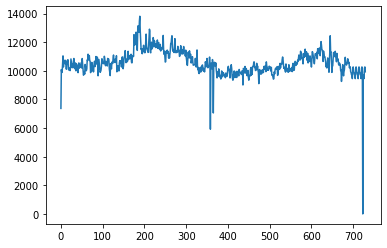

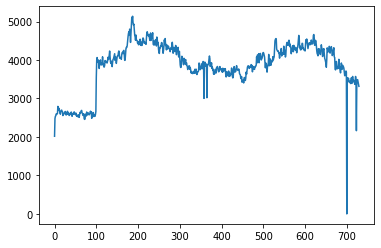

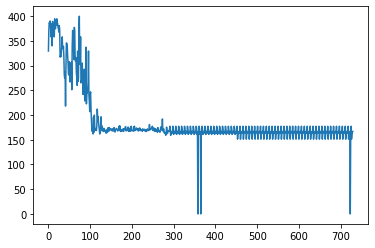

In [ ]:
defaulters = list(filter2.index)
for user in defaulters:
  subset = df_day_feat[df_day_feat['user'] == user]
  subset = subset.reset_index()
  plt.plot(subset['sum_per_day'])
  plt.show()

